# 2장. 머신러닝 프로젝트 처음부터 끝까지

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import pandas as pd
#filename =  "/content/.../dataname.csv"
#tremnd_w_demo = pd.read_csv(filename)

# 1. 데이터 내려받기

In [ ]:
import os 
import tarfile
import urllib
import urllib.request

### 데이터 다운로드

In [ ]:
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
housing_path = os.path.join("datasets, housing")
housing_url = download_root + "datasets/housing/housing.tgz"

* fetch_housing_data를 호출하면 현재 작업공간에 datasets/housing 디렉터리를 만들고 housing.tgz 파일을 내려받은 후 동일 디렉터리에 압축을 풀어서 housing.csv 파일을 만듦.

In [ ]:
def fetch_housing_data(housing_url = housing_url, housing_path = housing_path) :
  os.makedirs(housing_path, exist_ok = True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path = housing_path)
  housing_tgz.close()

In [ ]:
# fetch_housing_data 호출 
fetch_housing_data(housing_url, housing_path)

In [ ]:
# housing.csv 파일 불러들이기 
import pandas as pd
def load_housing_data(housing_path = housing_path) :
  csv_path = "/content/datasets, housing/housing.csv"
  return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()

### 데이터 훑어보기

In [ ]:
# 처음 다섯 개의 행을 보여줌
housing.head() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
# 데이터 기본 정보 확인
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 총 20640개의 샘플로 구성되어 있는데, total_bedrooms의 경우에는 20433개의 non-null값으로, 결측치가 있다는 것을 확인할 있다.<br>
$\rightarrow$ **이에 대한 전처리 필요**

In [ ]:
# Dtype이 object인 변수 확인 
housing.ocean_proximity.value_counts() 

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

* Ocean_proximity는 5개의 범주를 갖는 categorical 데이터

In [ ]:
# 연속형 변수들의 기본적인 통계량 요약
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* total_bedrooms의 경우는 결측치를 포함하지 않은 값들의 요약 통계량

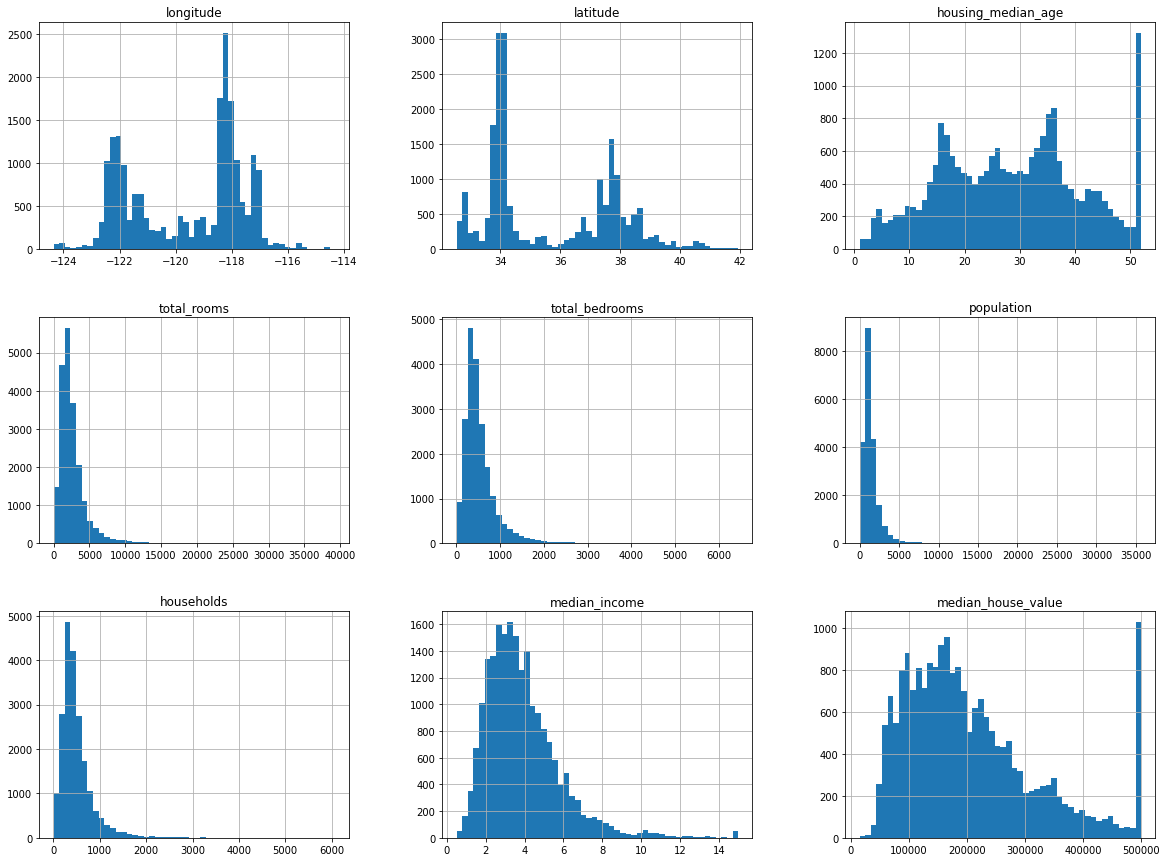

In [ ]:
# 연속형 변수들의 히스토그램
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

### 테스트 셋 만들기 <br>
머신러닝 학습 후 과대 또는 과소적합의 여부를 파악하기 위한 test set을 미리 만들어 놓고 모형 학습에는 적용하지 않음. 

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(housing, test_size = 0.2, random_state = 42)

* 순수한 무작위 샘플링 방식. 데이터셋이 크면 일반적으로 괜찮지만, 그렇지 않으면 샘플링의 편향이 생길 가능성이 큼. 각 카테고리별 비율에 따라 그 비율이 유지되게끔 샘플링을 실시하는 게 좋음.

median_income이 중요한 변수라고 가정했을 때, 현재 median_income의 히스토그램을 살펴보면 1.5~6사이. 계층별로 충분한 샘플 수가 있게끔 이 변수를 다섯 개의 계층으로 나눔. (너무 많은 층으로 나누면 안 됨) <br>
*  이렇게 나눈 후 stratified sampling으로 test set 만들거임

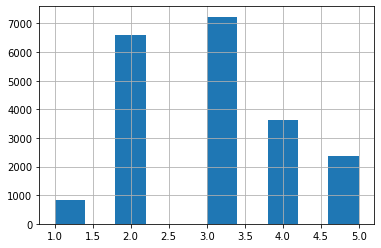

In [ ]:
import numpy as np
housing['income_cat'] = pd.cut(housing['median_income'], 
                               bins = [0, 1.5, 3.0, 4.5, 6, np.inf], 
                               labels = [1, 2, 3, 4, 5])
# category = 1 : 0 ~ 1.5
# category = 2 : 1.5 ~ 3.0
housing.income_cat.hist()

* 위에서 만든 income_cat에 대한 카테고리를 기준으로 stratified split 시행

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) # 객체화
for train_index, test_index in split.split(housing, housing['income_cat']) :
  strat_train = housing.loc[train_index]
  strat_test = housing.loc[test_index]

In [ ]:
# test data의 income_cat의 비율 확인
strat_test['income_cat'].value_counts() / len(strat_test)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [ ]:
# 데이터 원상복구
# income_cat 삭제하기
for set_ in (strat_train, strat_test) :
  set_.drop("income_cat", axis = 1, inplace = True)

# 2. 데이터 이해를 위한 탐색과 시각화 <br>
train 데이터만을 가지고 데이터 탐색

### 지리적 데이터 시각화

In [ ]:
housing = strat_train.copy()

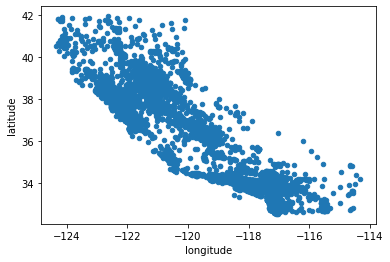

In [ ]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

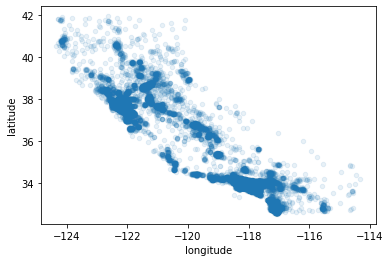

In [ ]:
# 데이터 포인트가 밀집된 부분만 진하게 그림
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1) # alpha는 투명도를 나타냄

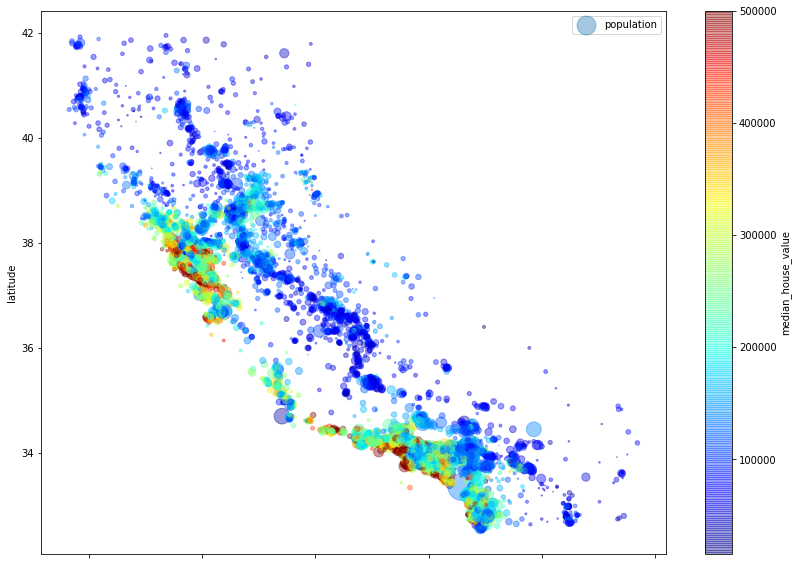

In [ ]:
# 각 구역마다 주택 가격과 인구 밀집도 나타내기
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, 
             s = housing['population'] / 50, label = "population", figsize = (14, 10), 
             c = "median_house_value", cmap = plt.get_cmap('jet'), colorbar = True)
plt.legend()
# s : 원의 반지름. c : 원의 색상, 
# cmap : colormap => 미리 정의된 컬러 맵

In [ ]:
# 실제 california 지도와 mapping하기
import os
project_root_dir = "."
chapter_id = "ene_to_end_project"
images_path = os.path.join(project_root_dir, "images", chapter_id)
os.makedirs(images_path, exist_ok=True)

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(images_path, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
download_root = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = download_root + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/ene_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f5f47e51780>)

그림 저장: california_housing_prices_plot


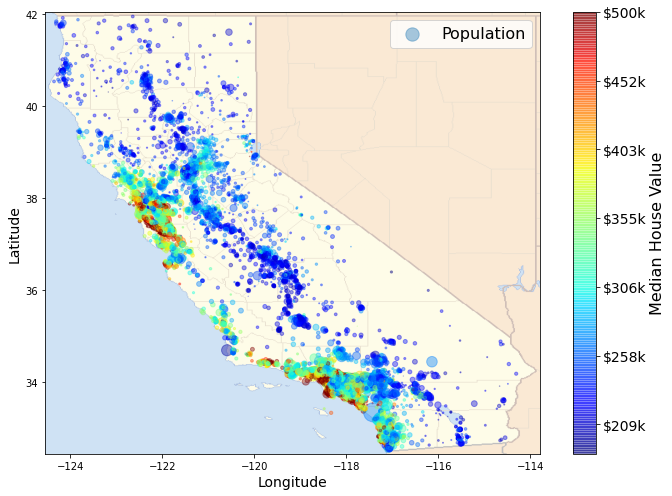

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

* 위의 그림을 통해 탐색해본 결과, 주택가격은 지역과 인구 밀도와 관계가 있다고 파악됨. 

### 상관관계 조사

In [ ]:
housing.ocean_proximity.head() # 이 변수는 범주형이기 때문에 correlation 못 구함

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
Name: ocean_proximity, dtype: object

In [ ]:
# 연속형 변수들에 대한 correlation 
corr_matrix = housing.corr()
# median_house_value와 상관계수가 높은 순으로 배열
corr_matrix['median_house_value'].sort_values(ascending = False)  

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

correlation 값은 선형관계만을 나타내는 것으로, 0과 가깝다고 해서 관계가 아예 없는 건 아님. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f47e53278>,
      dtype=object)

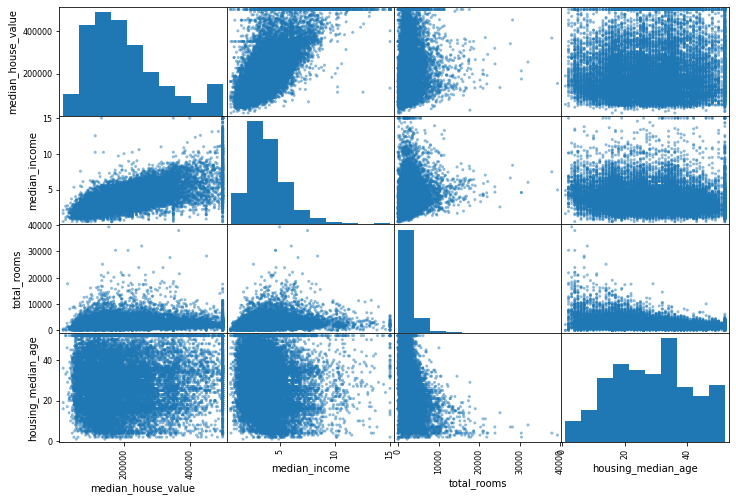

In [ ]:
# correlation 산점도 그리기
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize = (12, 8))

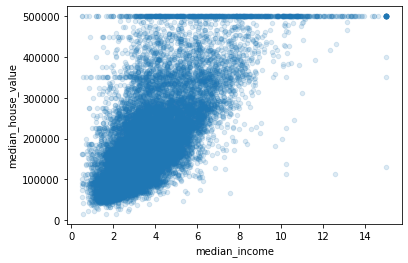

In [ ]:
# median_house_value와 가장 관계가 깊어 보이는 median_inocme의 산점도
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.15)

50000, 35000, 28000, 18000 부근에 직선에 가까운 형태가 보임. 알고리즘이 이 부분을 학습하지 않게끔 해당 구역을 제거해야함. (이유를 생각해보면,, 추세가 오른쪽 위로 향하는 양의 상관성이 나타나는데, 저런 부분은 둘의 관계가 없다는 것을 보여주는 부분이므로...?)

### 특성 조합으로 실험

In [ ]:
housing.population.head()

17606     710.0
18632     306.0
14650     936.0
3230     1460.0
3555     4459.0
Name: population, dtype: float64

In [ ]:
housing.households.head()

17606     339.0
18632     113.0
14650     462.0
3230      353.0
3555     1463.0
Name: households, dtype: float64

In [ ]:
housing.total_rooms.head()

17606    1568.0
18632     679.0
14650    1952.0
3230     1847.0
3555     6592.0
Name: total_rooms, dtype: float64

In [ ]:
housing.total_bedrooms.head()

17606     351.0
18632     108.0
14650     471.0
3230      371.0
3555     1525.0
Name: total_bedrooms, dtype: float64

In [ ]:
# 데이터 변형 
# 1. 가구당 방 개수
# 2. 방 개수 대비 전체 침대 개수
# 3. 가구당 대비 인구 수

housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

전체 방 대비 침대 비율이 낮을 수록 더 비싼 주택 가격을 나타냄. 또한 가구당 방의 개수도 전체 방의 개수보다 더 높은 상관계수를 보여줌. 

# 3. 머신러닝 알고리즘을 위한 데이터 준비

In [ ]:
strat_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [ ]:
# 훈련데이터를 특성변수와 목적변수로 나눔
housing = strat_train.drop("median_house_value", axis = 1)
housing_labels = strat_train['median_house_value'].copy()

### 데이터 정제
결측값 처리

In [ ]:
# 1. 결측치를 제거하는 방법
# housing.dropna(subset = ['total_bedrooms'])
# housing.drop('total_bedrooms', axis = 1)
# 2. 결측치가 포함된 그 특성 자체를 삭제 (여기선 생략)
# 3. 결측치를 다른 값으로 대체
# median = housing['total_bedrooms'].median() 
# housing['total_bedrooms'].fillna(median, inplace = True)

sklearn의 simpleimputer는 누락된 값의 정제를 쉽게 도와줌

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")  # simple imputer 객체 설정

# 숫자형 데이터의 중간값 구하기
housing_num = housing.drop("ocean_proximity", axis = 1) # 범주형 객체 삭제
imputer.fit(housing_num) # 연속형 자료들에 대해서만 median 값 구함 
imputer.statistics_  # numpy 배열

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [ ]:
X = imputer.transform(housing_num)
X # 결측값이 median으로 채워진 numpy array

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [ ]:
# 결측값들이 채워진 연속형 변수들의 데이터 프레임 
housing_tr = pd.DataFrame(X, columns = housing_num.columns, 
                          index = housing_num.index)

In [ ]:
# 사이킷런의 설계 철학 (p.101)

### 텍스트와 범주형 특성 다루기

In [ ]:
housing_cat = housing[['ocean_proximity']]
# housing['ocean_proximity']은 튜플을 형성
housing_cat

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
...,...
6563,INLAND
12053,INLAND
13908,INLAND
11159,<1H OCEAN


문자형 데이터를 숫자로 바꿈

In [ ]:
from sklearn.preprocessing import OrdinalEncoder # 이건 순서형으로 보는건데
ordinal_encoder = OrdinalEncoder()  # 객체화
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # 데이터 프레임 들어가야 함
housing_cat_encoded[:10] # 처음 열 개 출력

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [ ]:
# 어떤 변수가 어떤 값으로 encoding 되었는지 확인 
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

* 방금 수행한 인코딩은 순서형 자료를 위한 것으로, 서로 가까이 있는 범주(ex. 1과 2)가 서로 멀리 있는 범주보다(ex. 1과 4) 가깝다고 생각함.

one-hot encoding 시행

In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat) # df 들어가야 함. 
housing_cat_1hot # sparse matrix 

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [ ]:
# numpy 형태
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 나만의 변환기(p.106) <br> 
* duck typing : 상속이나 인터페이스 구현이 아니라 객체의 속성이나 매서드가 객체의 유형을 결정하는 방식

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
 
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
 
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args나 **kargs가 아님
        self.add_bedrooms_per_room = add_bedrooms_per_room
 
    def fit(self, X, y=None):
        return self # 더 할 일이 없습니다.
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [ ]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### 특성 스케일링 <br> 
* min-max 스케일링 (정규화) : ${ X - \mbox{ min} \over \mbox{max - min}}$ <br> 
* 표준화 (standardization) : ${X - \mu} \over \sigma $ 

### 변환 파이프라인 <br>
연속된 단계를 나타내는 이름/추정기 쌍의 목록을 입력으로 받아, 차례대로 수행. 

In [ ]:
# 단계 순서대로 진행할 수 있게 pipeline 만듦 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

# 연속형 변수의 결측치를 채우는 pipeline
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy = "median")), 
                         ('attribs_adder', CombinedAttributesAdder()),
                         # CombineAttributesAdder()은 이해가 더 필요 
                         ('std_scaler', StandardScaler()) 
                         ]) 
# simpleimputer -> combineattributesadder -> standardscaler 순으로 진행
housing_prepared = num_pipeline.fit_transform(housing_num)

In [ ]:
from sklearn.compose import ColumnTransformer

# 숫자형 열과 범주형 열에 각각 변환을 적용하여 처리
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_attribs), 
                                   ("cat", OneHotEncoder(), cat_attribs)
                                   ])

housing_prepared = full_pipeline.fit_transform(housing)

# 모델 선택과 훈련
### 훈련 세트에서 훈련하고 평가하기

선형 회귀모형 훈련

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression() # 객체화
lin_reg.fit(housing_prepared, housing_labels) # 모델 훈련 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
# 예측한 것과 원래 값 비교 
print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

예측: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
레이블: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [ ]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared) # 훈련데이터 예측 
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

대부분 구역의 중간 주택 가격은 \$ 120,000에서 \$265,000 사이인데, RMSE가 60,000을 넘어가는 것은 훈련데이터에 과소적합된 사례로 볼 수 있다. 

의사결정나무모형 적용

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()  # 객체화
tree_reg.fit(housing_prepared, housing_labels) # 모델 훈련 
housing_predictions = tree_reg.predict(housing_prepared) # 훈련데이터 예측
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse 

0.0

RMSE값이 0인 것을 확인함으로써 모형이 훈련데이터에 과대적합 되었다는 것을 알 수 있음. 

### 교차 검증을 사용한 평가 <br>
훈련데이터를 더 작은 훈련데이터와 검증데이터로 나누고, 그 작은 훈련데이터에서 학습시킨 모형을 검증데이터를 이용하여 평가함. 

In [ ]:
# k-fold cross-validation
from sklearn.model_selection import cross_val_score
# 나무 모형을 k-fold 교차검증 실시 
# 모형, 특성변수, 목적변수, .., fold 수
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                         scoring = "neg_mean_squared_error", cv = 10)
# neg_mean_squared_error : -MSE 
tree_rmse_scores = np.sqrt(-scores)

사이킷런의 교차검증은, scoring 매개변수에 낮을수록 좋은 비용함수가 아닌 높을수록 좋은 효용함수를 적용. 따라서 MSE에 -를 붙임.

In [ ]:
tree_rmse_scores # 10번의 folds에 대한 RMSE값 출력

array([68892.74860394, 65679.57050901, 72488.66965526, 69985.20020783,
       71955.78835181, 73849.67594945, 70962.21091362, 71164.77491891,
       75190.39606793, 68663.30224206])

In [ ]:
def display_scores(scores) :
  print("점수:", scores)
  print("평균:", scores.mean())
  print("표준편차:", scores.std())

In [ ]:
display_scores(tree_rmse_scores)

점수: [68892.74860394 65679.57050901 72488.66965526 69985.20020783
 71955.78835181 73849.67594945 70962.21091362 71164.77491891
 75190.39606793 68663.30224206]
평균: 70883.23374198184
표준편차: 2606.5193186089828


In [ ]:
# 선형 회귀모형에 대해 교차검증
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, 
                             scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [ ]:
display_scores(lin_rmse_scores)

점수: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
평균: 69052.46136345083
표준편차: 2731.674001798344


선형 회귀모형이 의사결정나무 모형보다 rmse값이 상대적으로 작으므로 성능이 조금 더 좋다고 볼 수 있음. 

In [ ]:
# randomforest 모형 (앙상블 학습)
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor() # 객체화 
forest_reg.fit(housing_prepared, housing_labels) # 모형 적합

# 훈련데이터를 이용하여 예측
housing_predictions = forest_reg.predict(housing_prepared)
ranfo_mse = mean_squared_error(housing_labels, housing_predictions)
ranfo_rmse = np.sqrt(ranfo_mse)
ranfo_rmse  # rmse값이 다른 모형에 비해서 훨씩 작음 

18581.588501618793

In [ ]:
# 10-fold cross validation
from sklearn.model_selection import cross_val_score
ranfo_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                               scoring = "neg_mean_squared_error", cv = 10)
ranfo_rmse_scores = np.sqrt(-ranfo_scores)
display_scores(ranfo_rmse_scores)

점수: [49624.71069051 47249.52213223 50101.80467284 52121.76862257
 49407.67906497 53244.62172616 49049.31561631 48312.44109494
 52874.95882594 49999.64213055]
평균: 50198.64645770338
표준편차: 1863.305964267407


실험데이터에 대해서는 rmse값이 18000정도였는데 검증데이터에 대해서는 rmse 값이 50000으로 매우 커지는 것을 알 수 있음. 이 또한 훈련데이터에 과대적합 되었음을 의미.

### 실험한 모델 저장

In [ ]:
import joblib
joblib.dump(ranfo_scores, "ranfo_scores.pkl")

['ranfo_scores.pkl']

# 모델 세부 튜닝

### 그리드 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [ {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]}, # 첫 번째 dictionary 
               {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]} ] # 두 번째 dictionary 

첫 번째 dictionary의 3 X 4 = 12개의 조합을 먼저 search. 
그 후에 두 번째 dictionary에 있는 2 X 3개의 조합을 search. <br>
그럼 총 search하는 건 12 + 6 = 18개이고, 총 5번의 cross validation을 시도한다면 90번의 훈련 횟수를 거침. 

In [ ]:
# gridsearch + cv
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, 
                           scoring = "neg_mean_squared_error", 
                           return_train_score = True)

In [ ]:
grid_search.fit(housing_prepared, housing_labels)  # 최적의 param을 이용하여 

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
grid_search.best_params_ 

{'max_features': 8, 'n_estimators': 30}

best_params_의 값이 주어진 파라미터들 중 가장 큰 것 값들이기 때문에 더 큰 값을 주고 다시 탐색해봐야 함. 

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params  in zip(cvres['mean_test_score'], cvres['params']) :
  print(np.sqrt(-mean_score), params)  

# zip 함수 사용법!

63999.32282927775 {'max_features': 2, 'n_estimators': 3}
55244.9718820753 {'max_features': 2, 'n_estimators': 10}
52692.08435667044 {'max_features': 2, 'n_estimators': 30}
60972.231700100056 {'max_features': 4, 'n_estimators': 3}
53409.775296813415 {'max_features': 4, 'n_estimators': 10}
50337.285724126414 {'max_features': 4, 'n_estimators': 30}
59149.303597790604 {'max_features': 6, 'n_estimators': 3}
52647.8084594482 {'max_features': 6, 'n_estimators': 10}
49961.18859108829 {'max_features': 6, 'n_estimators': 30}
58715.562465670824 {'max_features': 8, 'n_estimators': 3}
51943.38186747444 {'max_features': 8, 'n_estimators': 10}
49947.054741899046 {'max_features': 8, 'n_estimators': 30}
63163.68440398066 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53728.0617761726 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60150.2128970711 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52371.5391688902 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

기본 하이퍼파라미터 설정으로 얻은 rmse가 50182이었고, 최적의 파라미터의 설정으로 얻은 rmse가 49947으로 더 좋은 모형을 찾아냄. 

### 랜덤탐색 <br>
하이퍼파라미터 조합이 비교적 적은 수일 때는 gridsearch 이용해도 됨. 하지만, hyperparameter 공간이 커지면 randomizedsearchCV를 통해 최적의 모수를 찾도록 함. 

### 앙상블 방법 <br> 
최상의 모델을 연결해보는 것. 모델의 그룹이 최상의 단일 모델보다 더 나은 성능을 보여줄 때가 있음. 

### 최상의 모델과 오차 분석

각 특성의 상대적인 중요도 파악

In [88]:
feature_importances = grid_search.best_estimator_.feature_importances_
np.round(feature_importances, 2)

array([0.07, 0.06, 0.04, 0.02, 0.01, 0.01, 0.01, 0.36, 0.06, 0.11, 0.06,
       0.01, 0.16, 0.  , 0.  , 0.  ])

In [90]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

In [91]:
sorted(zip(feature_importances, attributes), reverse = True)  # zip함수... 꼭 알아야겠담

[(0.3605168830165061, 'median_income'),
 (0.16076441179539022, 'INLAND'),
 (0.11194338059865229, 'pop_per_hhold'),
 (0.07108064674318698, 'longitude'),
 (0.06473419801576824, 'bedrooms_per_room'),
 (0.061007565897837276, 'latitude'),
 (0.05597348424929653, 'rooms_per_hhold'),
 (0.04295079966030314, 'housing_median_age'),
 (0.015153882070051793, 'total_rooms'),
 (0.014735621204031485, 'population'),
 (0.014632965502123842, 'total_bedrooms'),
 (0.014442554113334683, 'households'),
 (0.0059107013911967494, '<1H OCEAN'),
 (0.003800177532847972, 'NEAR OCEAN'),
 (0.0022399670279939312, 'NEAR BAY'),
 (0.00011276118147879297, 'ISLAND')]

### 테스트 세트로 시스템 평가하기

In [93]:
# 최종모형
final_model = grid_search.best_estimator_

# 테스트 데이터 특성변수와 목적변수
X_test = strat_test.drop("median_house_value", axis = 1)
y_test = strat_test['median_house_value'].copy()

# 전처리
X_test_prepared = full_pipeline.transform(X_test)

# 최종 모형을 이용한 예측
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47709.60982594719